# POPULARITY AND UNIQUENESS OF A HIT SONG
**COMP2200: DATA SCIENCE GROUP PROJECT**

This group project was perform by **GROUP 71**. The following are the members of the group, along with their student ID numbers:

| Name | Student ID
| :--- | :---------
| Lance Te | 45581819
| Thomas Mansfield | 45381127
| Ava Gardiner | 46410961
| Darcey Burch | 45421706

# Executive Summary

According to ‘The State of the Music Industry’, Universal Music Group (32% market share), Sony Music Entertainment (20%), and Warner Music Group (16%) dominate 68% share of the music recording industry (Stone, 2021). On the other hand, these songs account for less than 1% of all music produced each year. For music enthusiasts, this means there are a lot more songs to uncover.  And, in reality, people are beginning to do so as a result of streaming services such as Spotify, Apple Music, and YouTube. Unlike radio, they do not just promote pop, rock, and country music. Consumers can extend their musical horizons by exploring lesser-known genres that are rarely heard on the radio.

As these music streaming services have grown in popularity, vast quantities of digital data have been made available. When paired with user interaction, this data can be utilised to answer a very simple question that all aspiring and accomplished artists ask: 

> WHAT MAKES A SONG UNIQUE, AND WHAT QUALITIES SHOULD A SONG HAVE IN ORDER TO BECOME A HIT? 


# Table of Contents
<ul>
<li><a href="#Introduction">Introduction</a></li>
<li><a href="#Data Preparation">Data Preparation</a></li>
<li><a href="#Exploratory Data Analysis">Exploratory Data Analysis</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ul>


<a id='Introduction'></a>
# Introduction

### Our Goal
The study's goal is to create correlations between multiple factors related to music, albums, and tracks in order to understand what qualities contribute to a hit song. The following indicators were employed in this study: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and duration, all of which were collected via Spotify's Web API. The data retrieved from Spotify is assigned a score in each category. 

Throughout this study, we will explore a variety of techniques to address the core question, including linear regression, clustering, and heat maps. We will also address sub-questions based on the core question to help us reach an overall conclusion. 

**Here are the following sub-questions:**

* What attributes should a song have to be successful?
* Is it possible for a song that sounds sadder or angry to become a hit? 
* Does the artist influence the popularity of a song? 
* Does the song need to be in a certain genre to be a hit? 
* Does a collaboration gain more popularity to a song that has a single artist?

We believe that our study will be useful to both new and established artists in creating songs that are targeted to their audience's expectations, as well as in increasing the reach of their songs.

### The Data

The data is retrieved from Spotify via their API. We collected song data from 2000-2021.


<a id='Data Preparation'></a>
# Data Preparation

In this section, data is acquired from Spotify's Web API and imported into Jupyter Notebook through the Spotipy package. We have have full access to libraries specifically designed by the Spotipy platform to acquire all types of music metadata, such as track name, album, release date, and popularity. Within these categories, using Spotipy and its libraries, we can extract multiple "Audio Features" such as danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and duration. 

We have installed Spotipy and imported all of the necessary libraries in the sections below. To help us with our data exploration, we have also imported pandas, matplotlib.pyplot, seaborn, and numpy. The three dataframes created below utilising the Spotipy package, 'data', 'features', and 'songs', have been saved into excel spreadsheets.

### Imports

In [1]:
# Handling / visualising data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE

# Classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# System utilities
import os
import time
from dotenv import load_dotenv

# Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### Client Setup

This is our our setup to access the Spotify API.

In [13]:
load_dotenv()
cid = os.getenv('cid')
secret = os.getenv('secret')

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spotify = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Retrieving Data

**Note:** Do not run this again. We've already got the data.

### Song IDs

The following function has been designed to filter songs between the years 2000 and 2022.
We have produced three excel files: 'songs', 'data', and 'features'. 

* songs.xlsx includes the artists_name, track_name, popularity, id and year. 
* data.xlsx includes the artists_name, track_name, popularity, id, year, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms and time_signature.
* features.xlsx includes song id, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms and time_signature.

In [21]:
%%time
songs = []
for year in range(2000, 2022):
    artist_name = []
    track_name = []
    popularity = []
    track_id = []
    for i in range(0, 1000, 50):
        query = f'year:{year}'
        track_results = spotify.search(q=query, type='track', limit=50, offset=i, market='AU')
        for i, t in enumerate(track_results['tracks']['items']):
            artist_name.append(t['artists'][0]['name'])
            track_name.append(t['name'])
            popularity.append(t['popularity'])
            track_id.append(t['id'])
    df = pd.DataFrame({'artist_name':artist_name,
                       'track_name':track_name,
                       'popularity':popularity,
                       'id':track_id})
    df['year'] = year
    songs.append(df)
    
combined = songs[0]
for i in range(1, len(songs)):
    combined = pd.concat([combined, songs[i]], axis = 0)
combined.reset_index(drop=True)
combined.to_excel('data/songs.xlsx', index=False)

Wall time: 2min 8s


### Song Metadata

The following ID's did not return any metadata:
* 5UBxtaGqAPCIYgVfa1OO4o
* 6MFQeWtk7kxWGydnJB2y36
* 04boE4u1AupbrGlI62WvoO
* 4OJ7lOioM7lgAWzKpiPJeC

In [22]:
song_id = pd.read_excel('data/songs.xlsx')
song_id = song_id.drop_duplicates(subset=['id']).reset_index(drop=True)

In [24]:
%%time
nrows = len(data)
bar = IntProgress(min=0, max=nrows) # Instantiate the bar
interface = HBox([bar])
display(interface)

failed_ids = []

features = pd.DataFrame()
for id in data['id']:
    try:
        features = spotify.audio_features(id)
        temp = pd.DataFrame.from_dict(features, orient='columns')
        temp = temp[['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
                     'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]
        features = pd.concat([features, temp], axis=0)
    except:
        failed_ids.append(id)
    bar.value += 1
    
features.to_excel('data/features.xlsx', index=False)

merged = pd.merge(song_id, features, on='id')
merged.to_excel('data/data.xlsx', index=False)

Wall time: 1h 1min 59s


In [8]:
failed_ids

['5UBxtaGqAPCIYgVfa1OO4o',
 '6MFQeWtk7kxWGydnJB2y36',
 '04boE4u1AupbrGlI62WvoO',
 '4OJ7lOioM7lgAWzKpiPJeC']

<a id='Exploratory Data Analysis'></a>
# Exploratory Data Analysis

Before fitting any data we explore the dataset and perform a number of checks to clean the dataset.

## Cleaning the dataset

The original dataset had 20,517 rows and 18 columns. After removing duplicates by `id` and dropping null values, the clean data set still consisted of 20,517 rows and 17 columns (the column descriptions are available in our readme). This indicates that there were **no null values** in the dataset.

In [2]:
features =['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness',
           'liveness', 'valence', 'tempo', 'duration']

In [3]:
data = pd.read_excel('data/data.xlsx')
print(data.shape)
data = data.drop('id', axis=1)
data = data.dropna(axis=0)
print(data.shape)

(20517, 18)
(20517, 17)


In [4]:
data.head(3)

artist_name    track_name  popularity  year  danceability  energy  key  \
0    Powderfinger  My Happiness          65  2000         0.445   0.823    0   
1  Jonas Brothers     Year 3000          67  2000         0.659   0.857   11   
2        Coldplay        Yellow          86  2000         0.429   0.661   11   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -5.415     1       0.0302       0.00163          0.000000     0.430   
1    -5.850     1       0.0437       0.00450          0.000002     0.335   
2    -7.227     1       0.0281       0.00239          0.000121     0.234   

   valence    tempo  duration_ms  time_signature  
0    0.487   85.935       276627               4  
1    0.798  106.965       201960               4  
2    0.285  173.372       266773               4

One thing we did notice was that the `duration_ms` column measured the duration of a track in milliseconds. To improve the interpretability of this column, we converted the column into minutes.

In [5]:
data['duration'] = data['duration_ms'] / 60000
data = data.drop(['duration_ms'], axis=1)
data.head()

artist_name           track_name  popularity  year  danceability  \
0    Powderfinger         My Happiness          65  2000         0.445   
1  Jonas Brothers            Year 3000          67  2000         0.659   
2        Coldplay               Yellow          86  2000         0.429   
3          Busted            Year 3000          65  2000         0.592   
4          Eminem  The Real Slim Shady          85  2000         0.949   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.823    0    -5.415     1       0.0302      0.001630          0.000000   
1   0.857   11    -5.850     1       0.0437      0.004500          0.000002   
2   0.661   11    -7.227     1       0.0281      0.002390          0.000121   
3   0.842   11    -6.681     1       0.0353      0.000219          0.000000   
4   0.661    5    -4.244     0       0.0572      0.030200          0.000000   

   liveness  valence    tempo  time_signature  duration  
0    0.4300    0.487   85.935               4  4.610450  
1    0.3350    0.798  106.965               4  3.366000  
2    0.2340    0.285  173.372               4  4.446217  
3    0.0934    0.898  107.015               4  3.270000  
4    0.0454    0.760  104.504               4  4.736667

Looking across the summaries of each column, there are a few things that stand out:

* A maximum duration of 80 minutes
* A minimum tempo of 0

These outliers require further investigation. The ranges of every other variable is reasonable.

In [6]:
data.describe()

popularity          year  danceability       energy           key  \
count  20517.000000  20517.000000  20517.000000  20517.00000  20517.000000   
mean      36.645855   2010.380611      0.574600      0.67755      5.320125   
std       29.330567      6.200431      0.168756      0.23426      3.578558   
min        0.000000   2000.000000      0.000000      0.00002      0.000000   
25%        5.000000   2005.000000      0.464000      0.53000      2.000000   
50%       45.000000   2010.000000      0.580000      0.72100      6.000000   
75%       63.000000   2016.000000      0.697000      0.87100      9.000000   
max      100.000000   2021.000000      0.987000      1.00000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  20517.000000  20517.000000  20517.000000  20517.000000   
mean      -7.787248      0.649656      0.086807      0.226934   
std        4.356551      0.477089      0.098615      0.297317   
min      -43.140000      0.000000      0.000000      0.000000   
25%       -9.150000      0.000000      0.036200      0.005490   
50%       -6.822000      1.000000      0.049700      0.070600   
75%       -5.084000      1.000000      0.087700      0.362000   
max        1.634000      1.000000      0.961000      0.996000   

       instrumentalness      liveness       valence         tempo  \
count      20517.000000  20517.000000  20517.000000  20517.000000   
mean           0.166703      0.223489      0.492796    122.624158   
std            0.317061      0.196113      0.251381     27.493310   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.097000      0.292000    102.002000   
50%            0.000080      0.137000      0.488000    124.948000   
75%            0.082600      0.299000      0.693000    137.983000   
max            1.000000      0.994000      0.989000    220.099000   

       time_signature      duration  
count    20517.000000  20517.000000  
mean         3.930497      3.881578  
std          0.373295      2.960352  
min          0.000000      0.290000  
25%          4.000000      3.008000  
50%          4.000000      3.637333  
75%          4.000000      4.323783  
max          5.000000     80.001967

### Duration

We can see that a few outliers cause the `duration` distribution to be significantly right-skewed. These outliers were determined to be unreasonable. When choosing a cut-off point, we used our domain knowledge that even some of the longer rap songs that employ a 3-part narrative structure lasts about 8 minutes. Hence we settled for an **8 minute duration cut-off**. The distribution appears relatively normal.

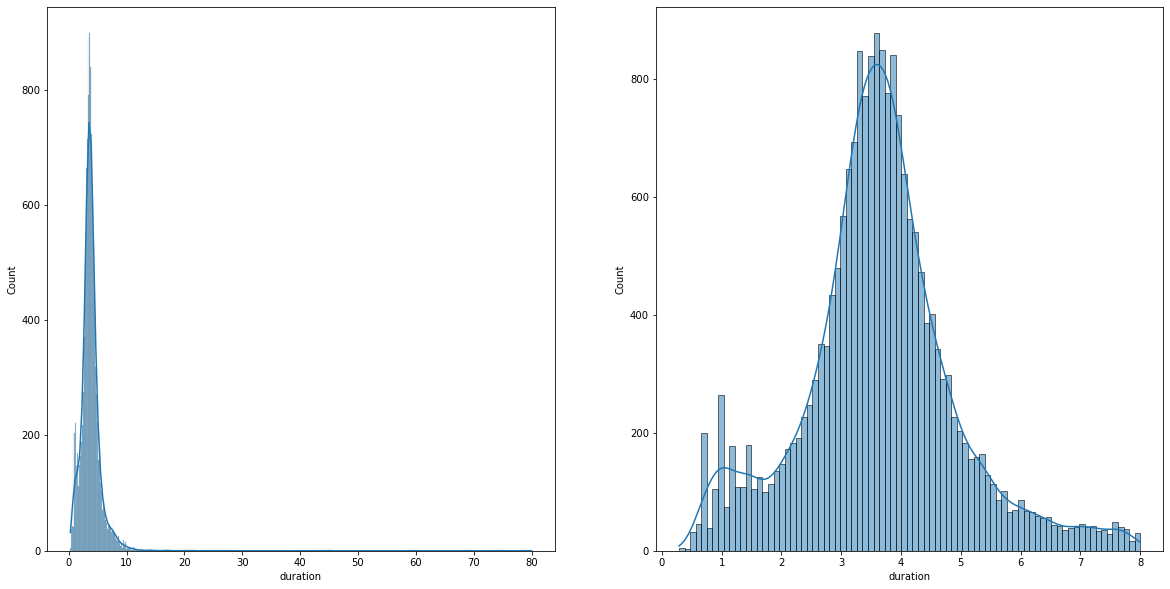

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.histplot(data['duration'], ax=ax[0], kde=True)
sns.histplot(data[data['duration']<=8]['duration'], ax=ax[1], kde=True)
plt.show()

In [8]:
data = data[data['duration']<=8]

### Tempo

There are 28 tracks with 0 `tempo`. We considered imputing these values. However, upon looking at the individual track names and artists, we ultimately decided to **exclude** these from the analysis. The distribution appears weakly normal.

In [9]:
tempo_outlier = data[data['tempo']<40][['artist_name', 'track_name', 'tempo']].reset_index(drop=True)
print(len(tempo_outlier))
display(tempo_outlier.head(3))

28


artist_name                track_name  tempo
0           Cafe BGM  Sultry Ambiance for 2021    0.0
1  atrabilis sunrise           Sleepless Years    0.0
2        Rain Sounds               White Noise    0.0

In [10]:
data = data[data['tempo']>=40]

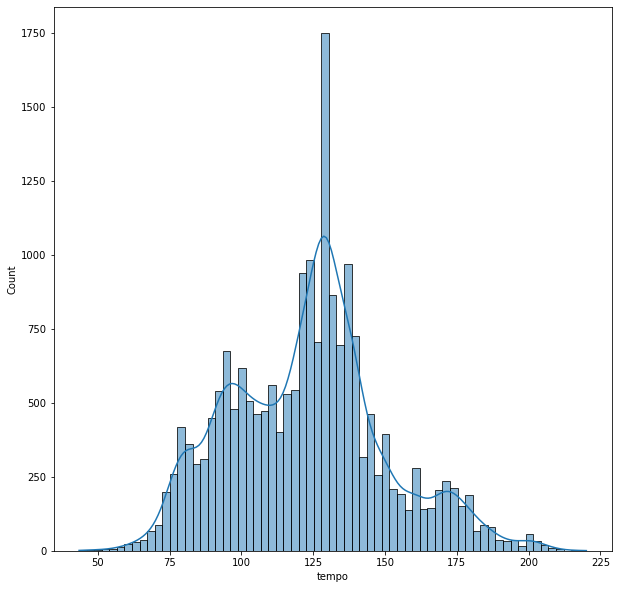

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data['tempo'], ax=ax, kde=True)
plt.show()

### Loudness

The `loudness` distribution is highly left skewed. We considered transforming the variable to satisfy the normality assumptions of a linear regression model by applying: `-np.log(-data['loudness']+1.634+1)`. We create another column with this transformation for when we perform linear regression. However, for the purposes of interpretability, we may decide against the variable transformation.

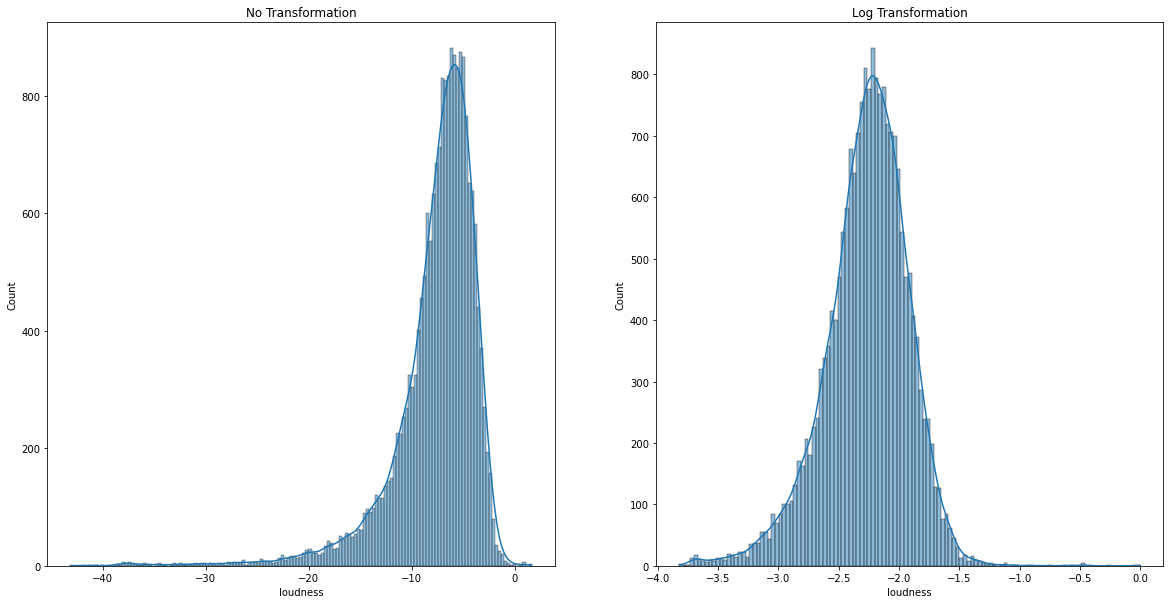

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.histplot(data['loudness'], ax=ax[0], kde=True)
sns.histplot(-np.log(-data['loudness']+1.634+1), ax=ax[1], kde=True)
ax[0].set_title('No Transformation')
ax[1].set_title('Log Transformation')
plt.show()

In [13]:
data['loudness_transform'] = -np.log(-data['loudness']+1.634+1)

### The other variables

[] Just looking at the distribution of the remaining variables in a fun way.

In [14]:
cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'mode']

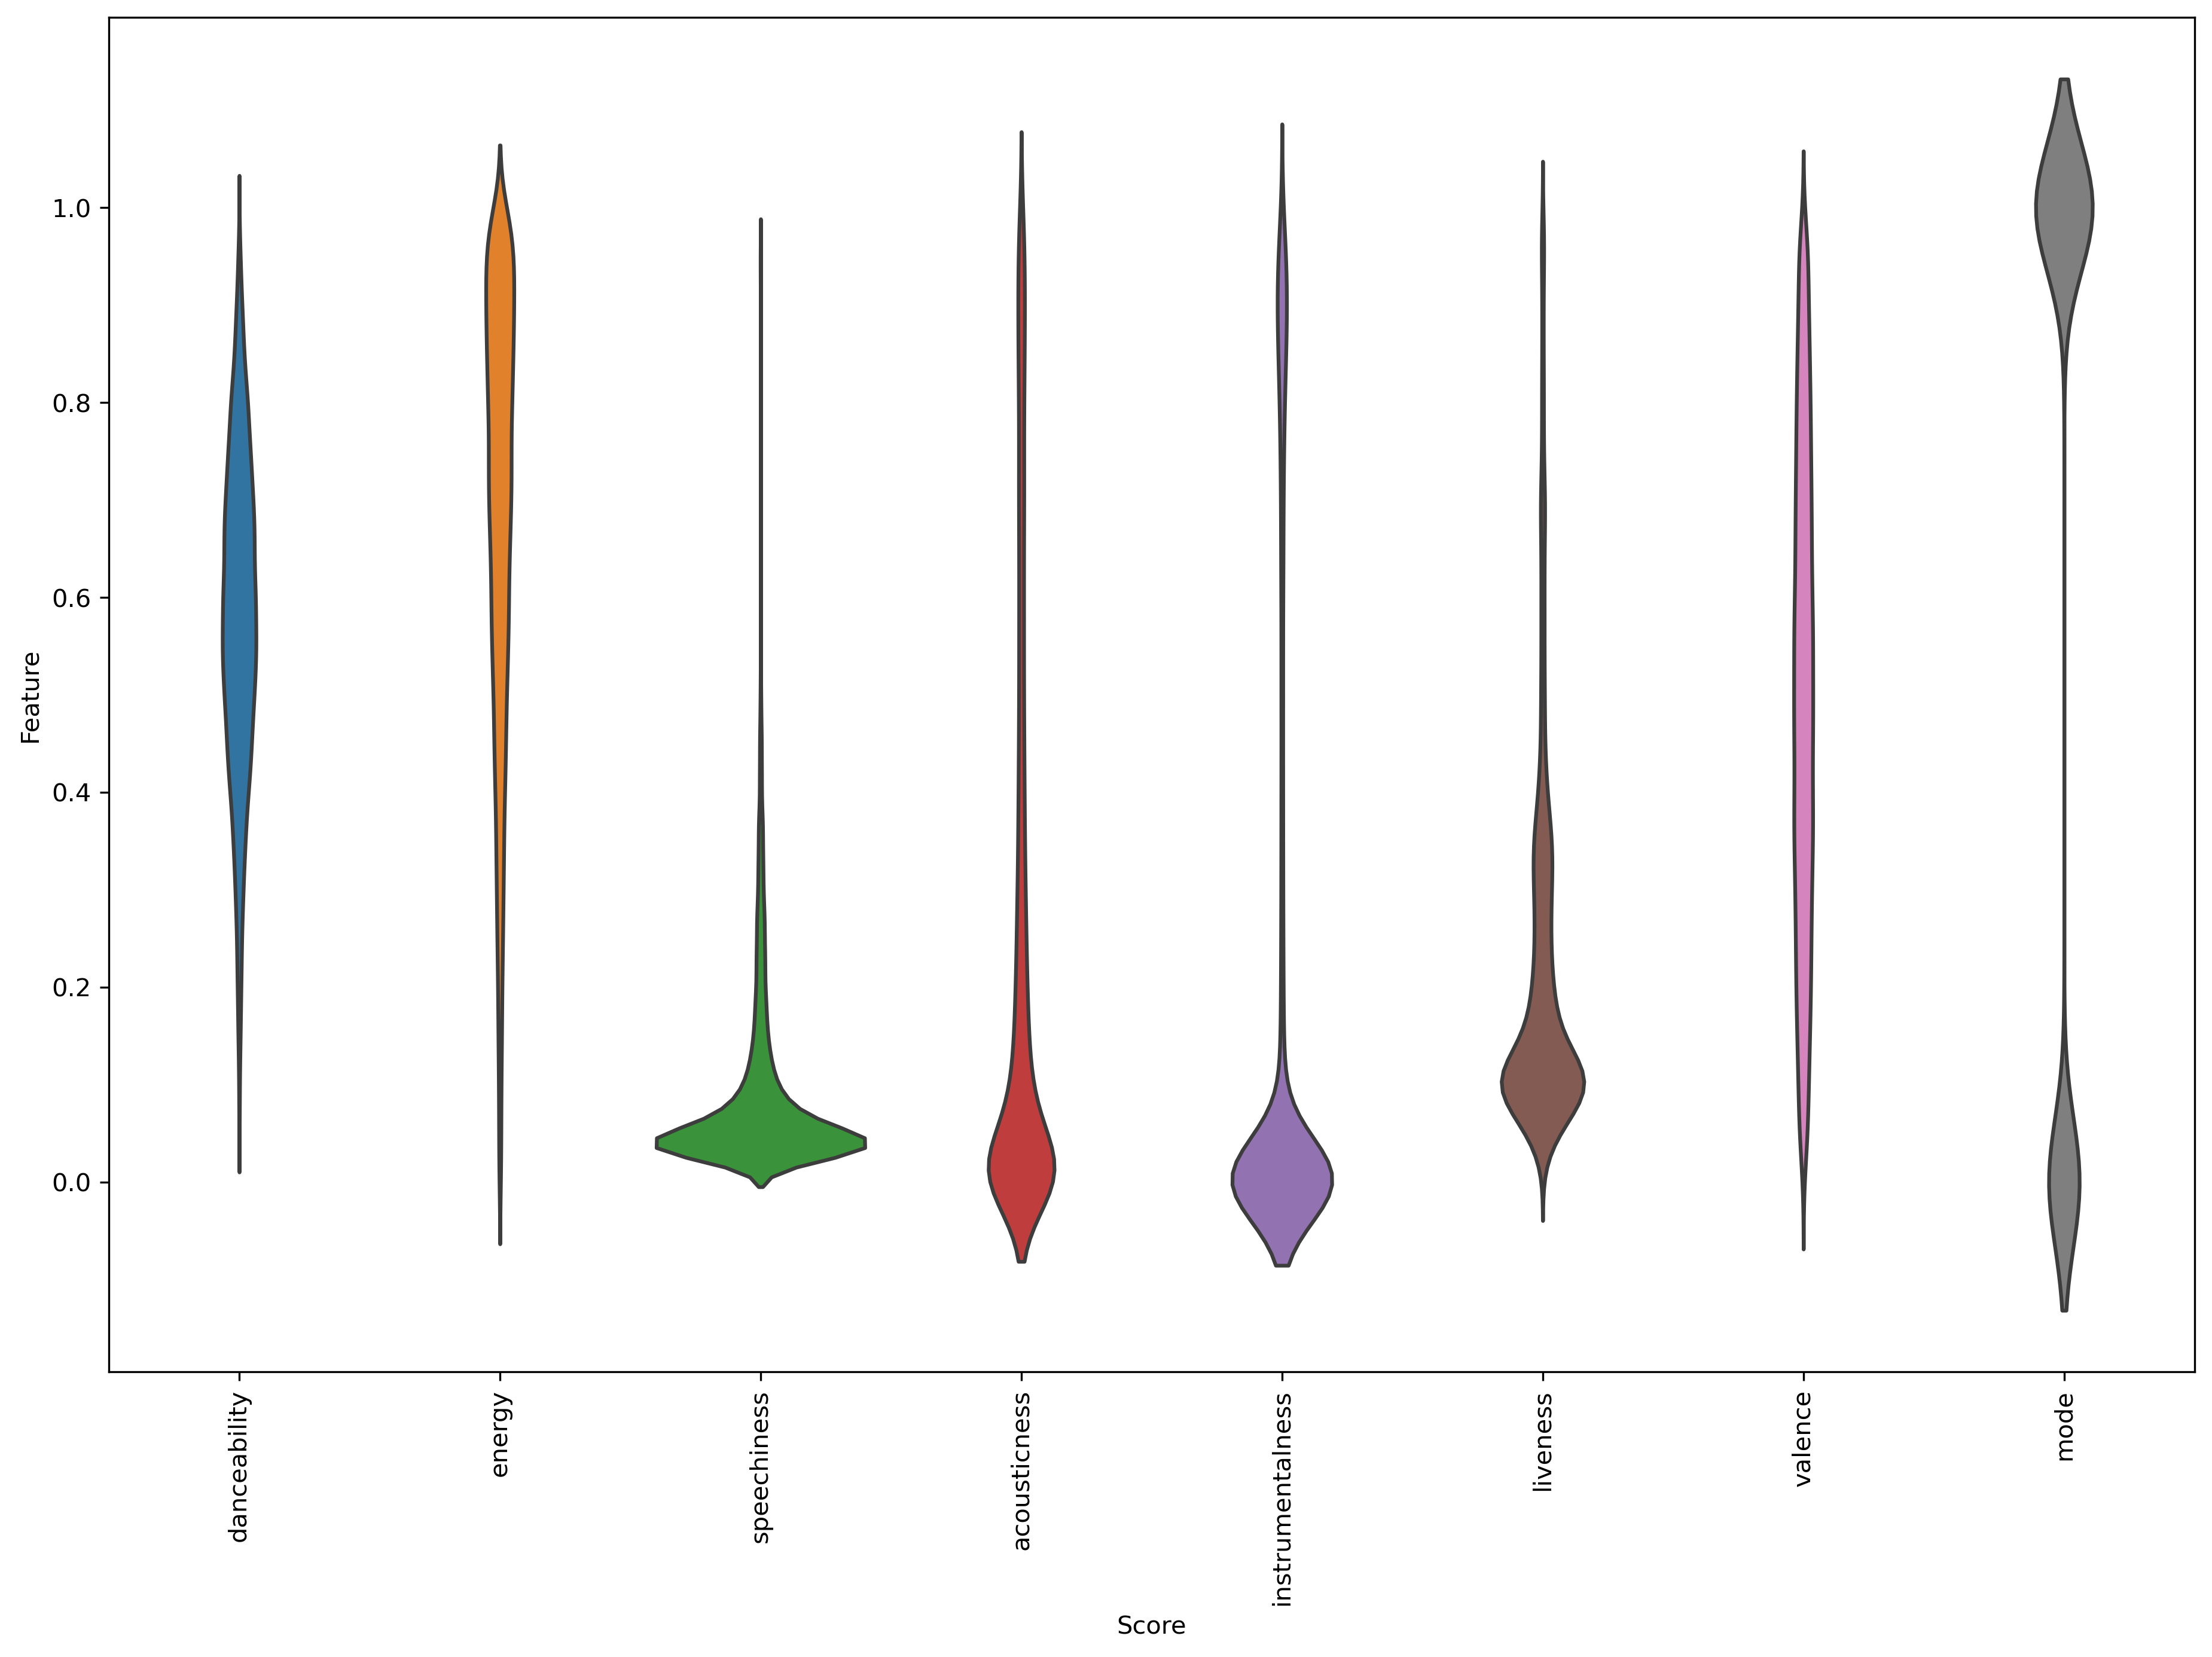

In [15]:
fig, ax = plt.subplots(figsize=(15,10), dpi=300)
sns.violinplot(data=data[cols], ax=ax, inner=None)
plt.xticks(rotation=90)
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

## Correlations

The lack of a clear correlation between the explanatory variables indicates it is unlikely that issues of multi-collinearity will arise. However, popularity is not highly correlated with any explanatory variable which indicates that a linear model may not be the most appropriate to model `popularity`.

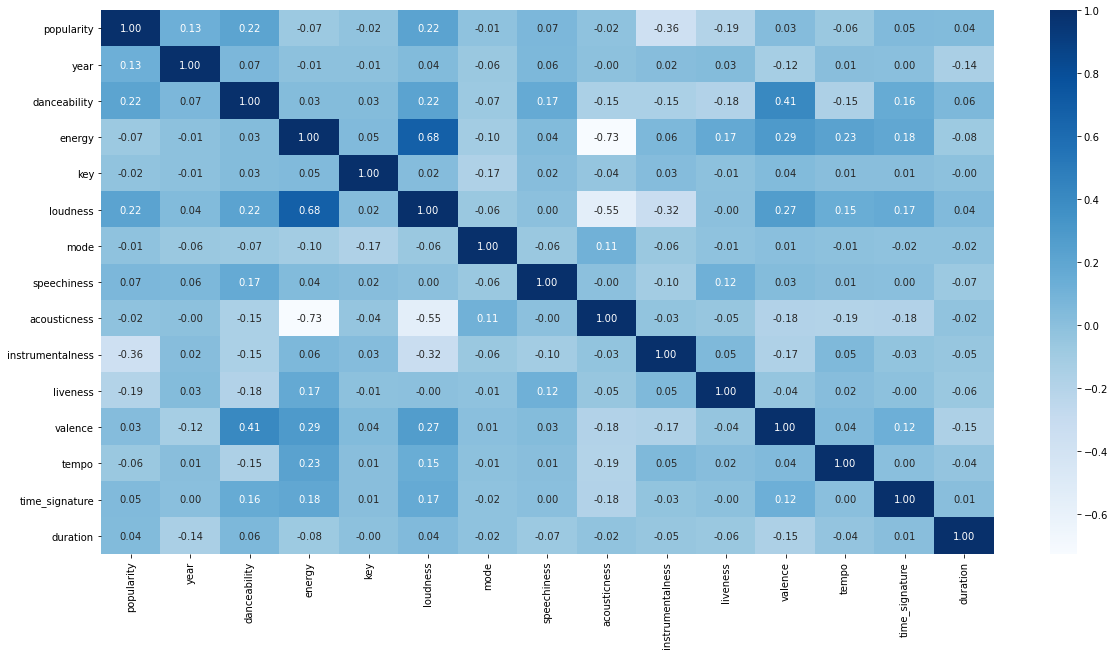

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.drop('loudness_transform', axis=1).corr(), annot=True, ax=ax,
            fmt='.2f', cmap=sns.color_palette('Blues', as_cmap=True))
plt.show()

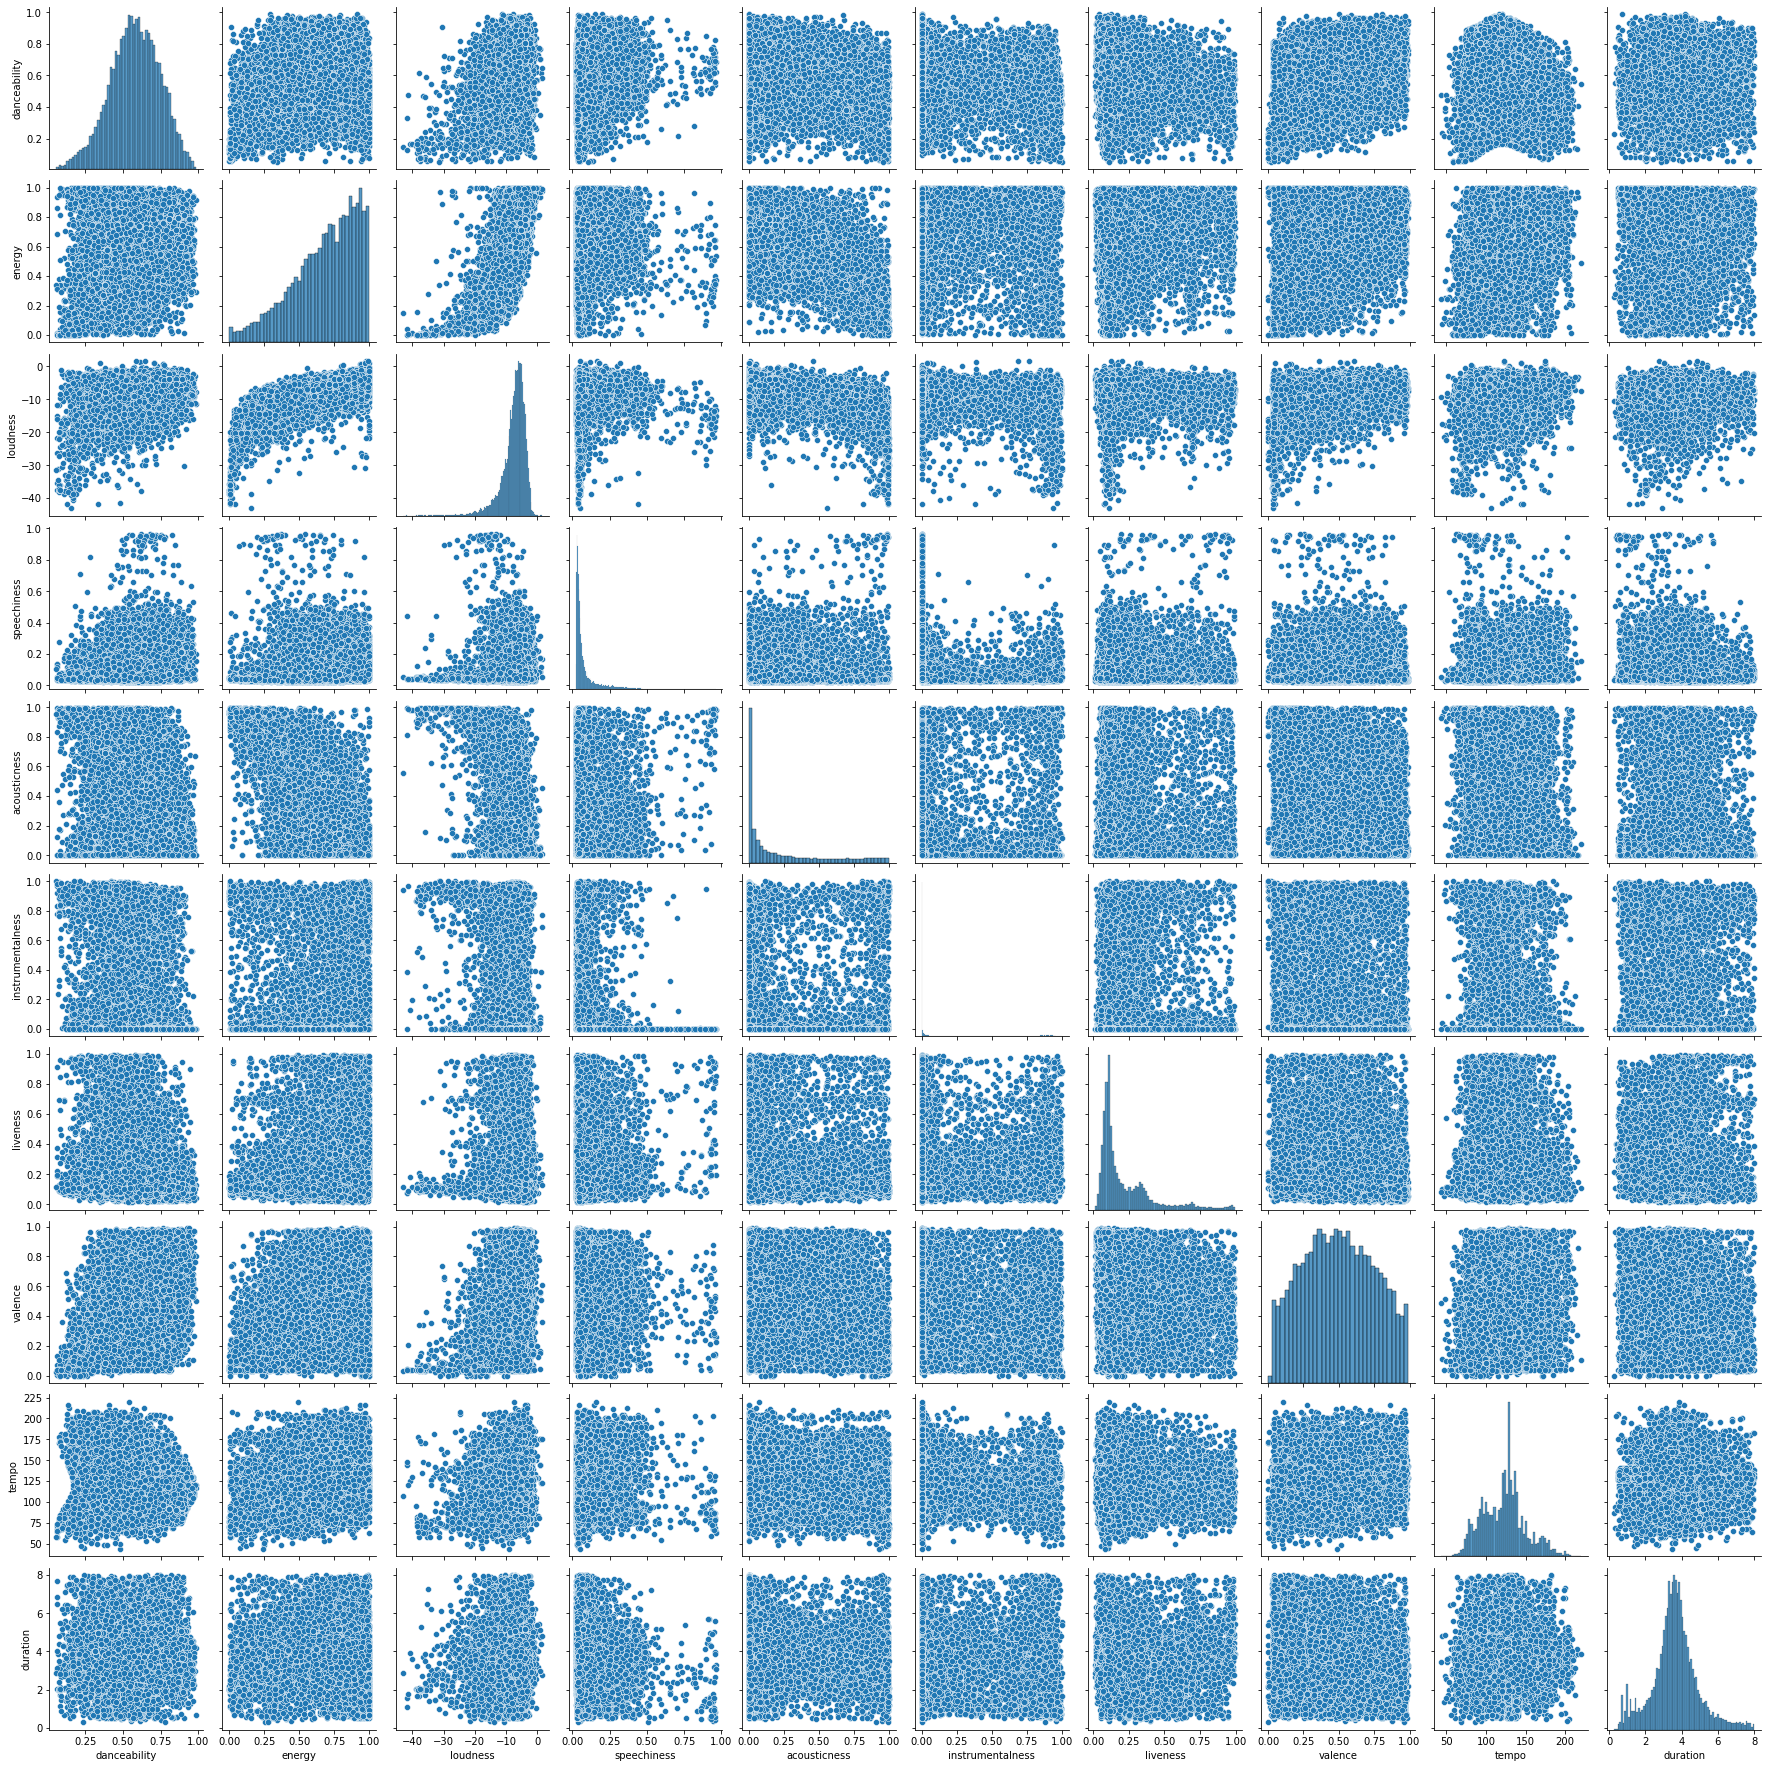

In [17]:
sns.pairplot(data[features])

## Clustering

To get a better understanding of the groupings in the dataset, we considered using K-means clustering. However, on closer inspection of a sample of the data, while there are clear clusters, we **cannot observe *meaningful*** clusters between `popularity` and the track features.

We looked more specifically at `popoularity` vs `danceability` using the within cluster sum of squares (WCSS) elbow-method to determine the optimal number of clusters as 2. This clustering is **not meaningful** as we see that songs can have drastically differing popularities despite having similar values of danceability.

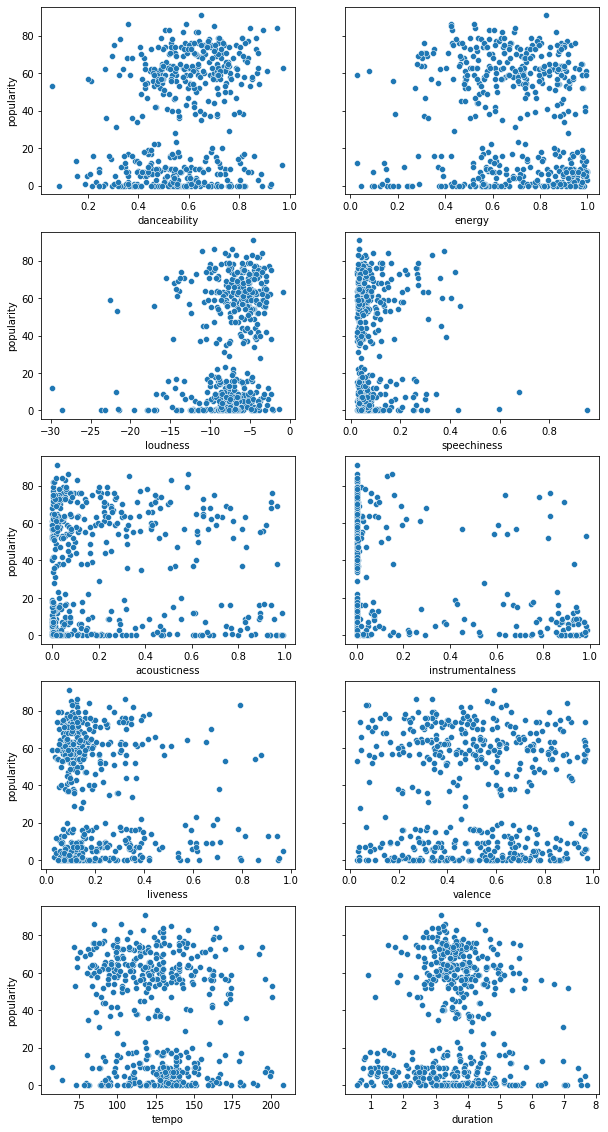

In [18]:
temp = data.sample(n=500, random_state=42)
fig, ax = plt.subplots(5, 2, figsize=(10,20), sharey=True)
for row in range(5):
    for col in range(2):
        sns.scatterplot(x=temp[features[row*2+col]], y=temp['popularity'], ax=ax[row, col])

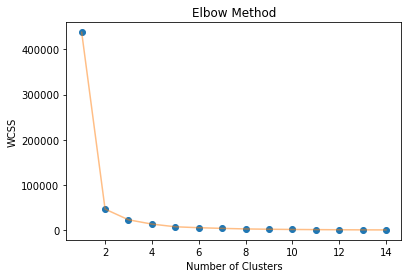

In [19]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(temp[['popularity', 'danceability']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1,15), wcss, 'o')
plt.plot(range(1,15), wcss, '-', alpha=0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

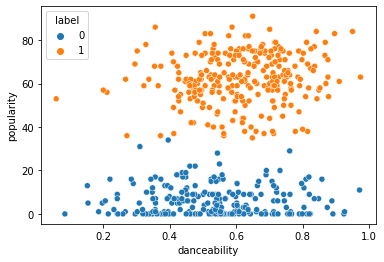

In [20]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(temp[['popularity', 'danceability']])

temp['label'] = kmeans.labels_
fig, ax = plt.subplots()
sns.scatterplot(x='danceability', y='popularity', hue='label', data=temp, ax=ax)
plt.show()

## Cleaned Data

Our final cleaned dataset has 19,995 rows and 18 columns.

In [21]:
print(data.shape)
display(data.head(3))

(19995, 18)


artist_name    track_name  popularity  year  danceability  energy  key  \
0    Powderfinger  My Happiness          65  2000         0.445   0.823    0   
1  Jonas Brothers     Year 3000          67  2000         0.659   0.857   11   
2        Coldplay        Yellow          86  2000         0.429   0.661   11   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -5.415     1       0.0302       0.00163          0.000000     0.430   
1    -5.850     1       0.0437       0.00450          0.000002     0.335   
2    -7.227     1       0.0281       0.00239          0.000121     0.234   

   valence    tempo  time_signature  duration  loudness_transform  
0    0.487   85.935               4  4.610450           -2.085548  
1    0.798  106.965               4  3.366000           -2.138182  
2    0.285  173.372               4  4.446217           -2.288588

In [22]:
data.to_csv('data/cleaned.csv', index=False)

# Trend Exploration

This section will look at the evolution of musical features over time. We have extracted song features from Spotify's API and created a table that displays the musical features in the horizontal row and years in the vertical column, and then combined this data to obtain a score that allows us to see if danceability, energy, key, loudness, and other features have increased, decreased, or remained the same from the 2000s to 2020. Below we have also displayed how musical features of popular songs have varied over time in a visual form.

In [23]:
data = pd.read_csv('data/cleaned.csv')
trends = copy.deepcopy(data)

To plot all variables on the same graph, we normalised `tempo`, `loudness`, and `duration`. Then, grouping by `year`, we can visualise how musical features have varied over time.

In [24]:
normalise = ['tempo', 'loudness', 'duration']
for var in normalise:
    trends[var] = (trends[var] - min(trends[var])) / (max(trends[var]) - min(trends[var]))

In [25]:
grouped = trends[trends['popularity']>70].groupby('year').agg('mean')
grouped.head()

popularity  danceability    energy       key  loudness      mode  \
year                                                                     
2000   75.200000      0.615514  0.720029  5.771429  0.832990  0.571429   
2001   74.305556      0.624889  0.792750  5.416667  0.842989  0.500000   
2002   74.575000      0.627925  0.702575  4.950000  0.836975  0.500000   
2003   75.000000      0.581115  0.722423  6.038462  0.841646  0.538462   
2004   74.307692      0.601718  0.730903  4.923077  0.831502  0.641026   

      speechiness  acousticness  instrumentalness  liveness   valence  \
year                                                                    
2000     0.077774      0.134423          0.029364  0.227737  0.584943   
2001     0.088044      0.119558          0.017982  0.213494  0.660861   
2002     0.066810      0.187899          0.000739  0.160727  0.517930   
2003     0.100535      0.171652          0.032948  0.164504  0.535473   
2004     0.116515      0.145700          0.027788  0.195974  0.522428   

         tempo  time_signature  duration  loudness_transform  
year                                                          
2000  0.406509        3.942857  0.489805           -2.109904  
2001  0.425237        3.972222  0.463489           -2.058388  
2002  0.436732        3.975000  0.512747           -2.090280  
2003  0.424946        4.000000  0.458780           -2.051120  
2004  0.455892        3.923077  0.466913           -2.078509

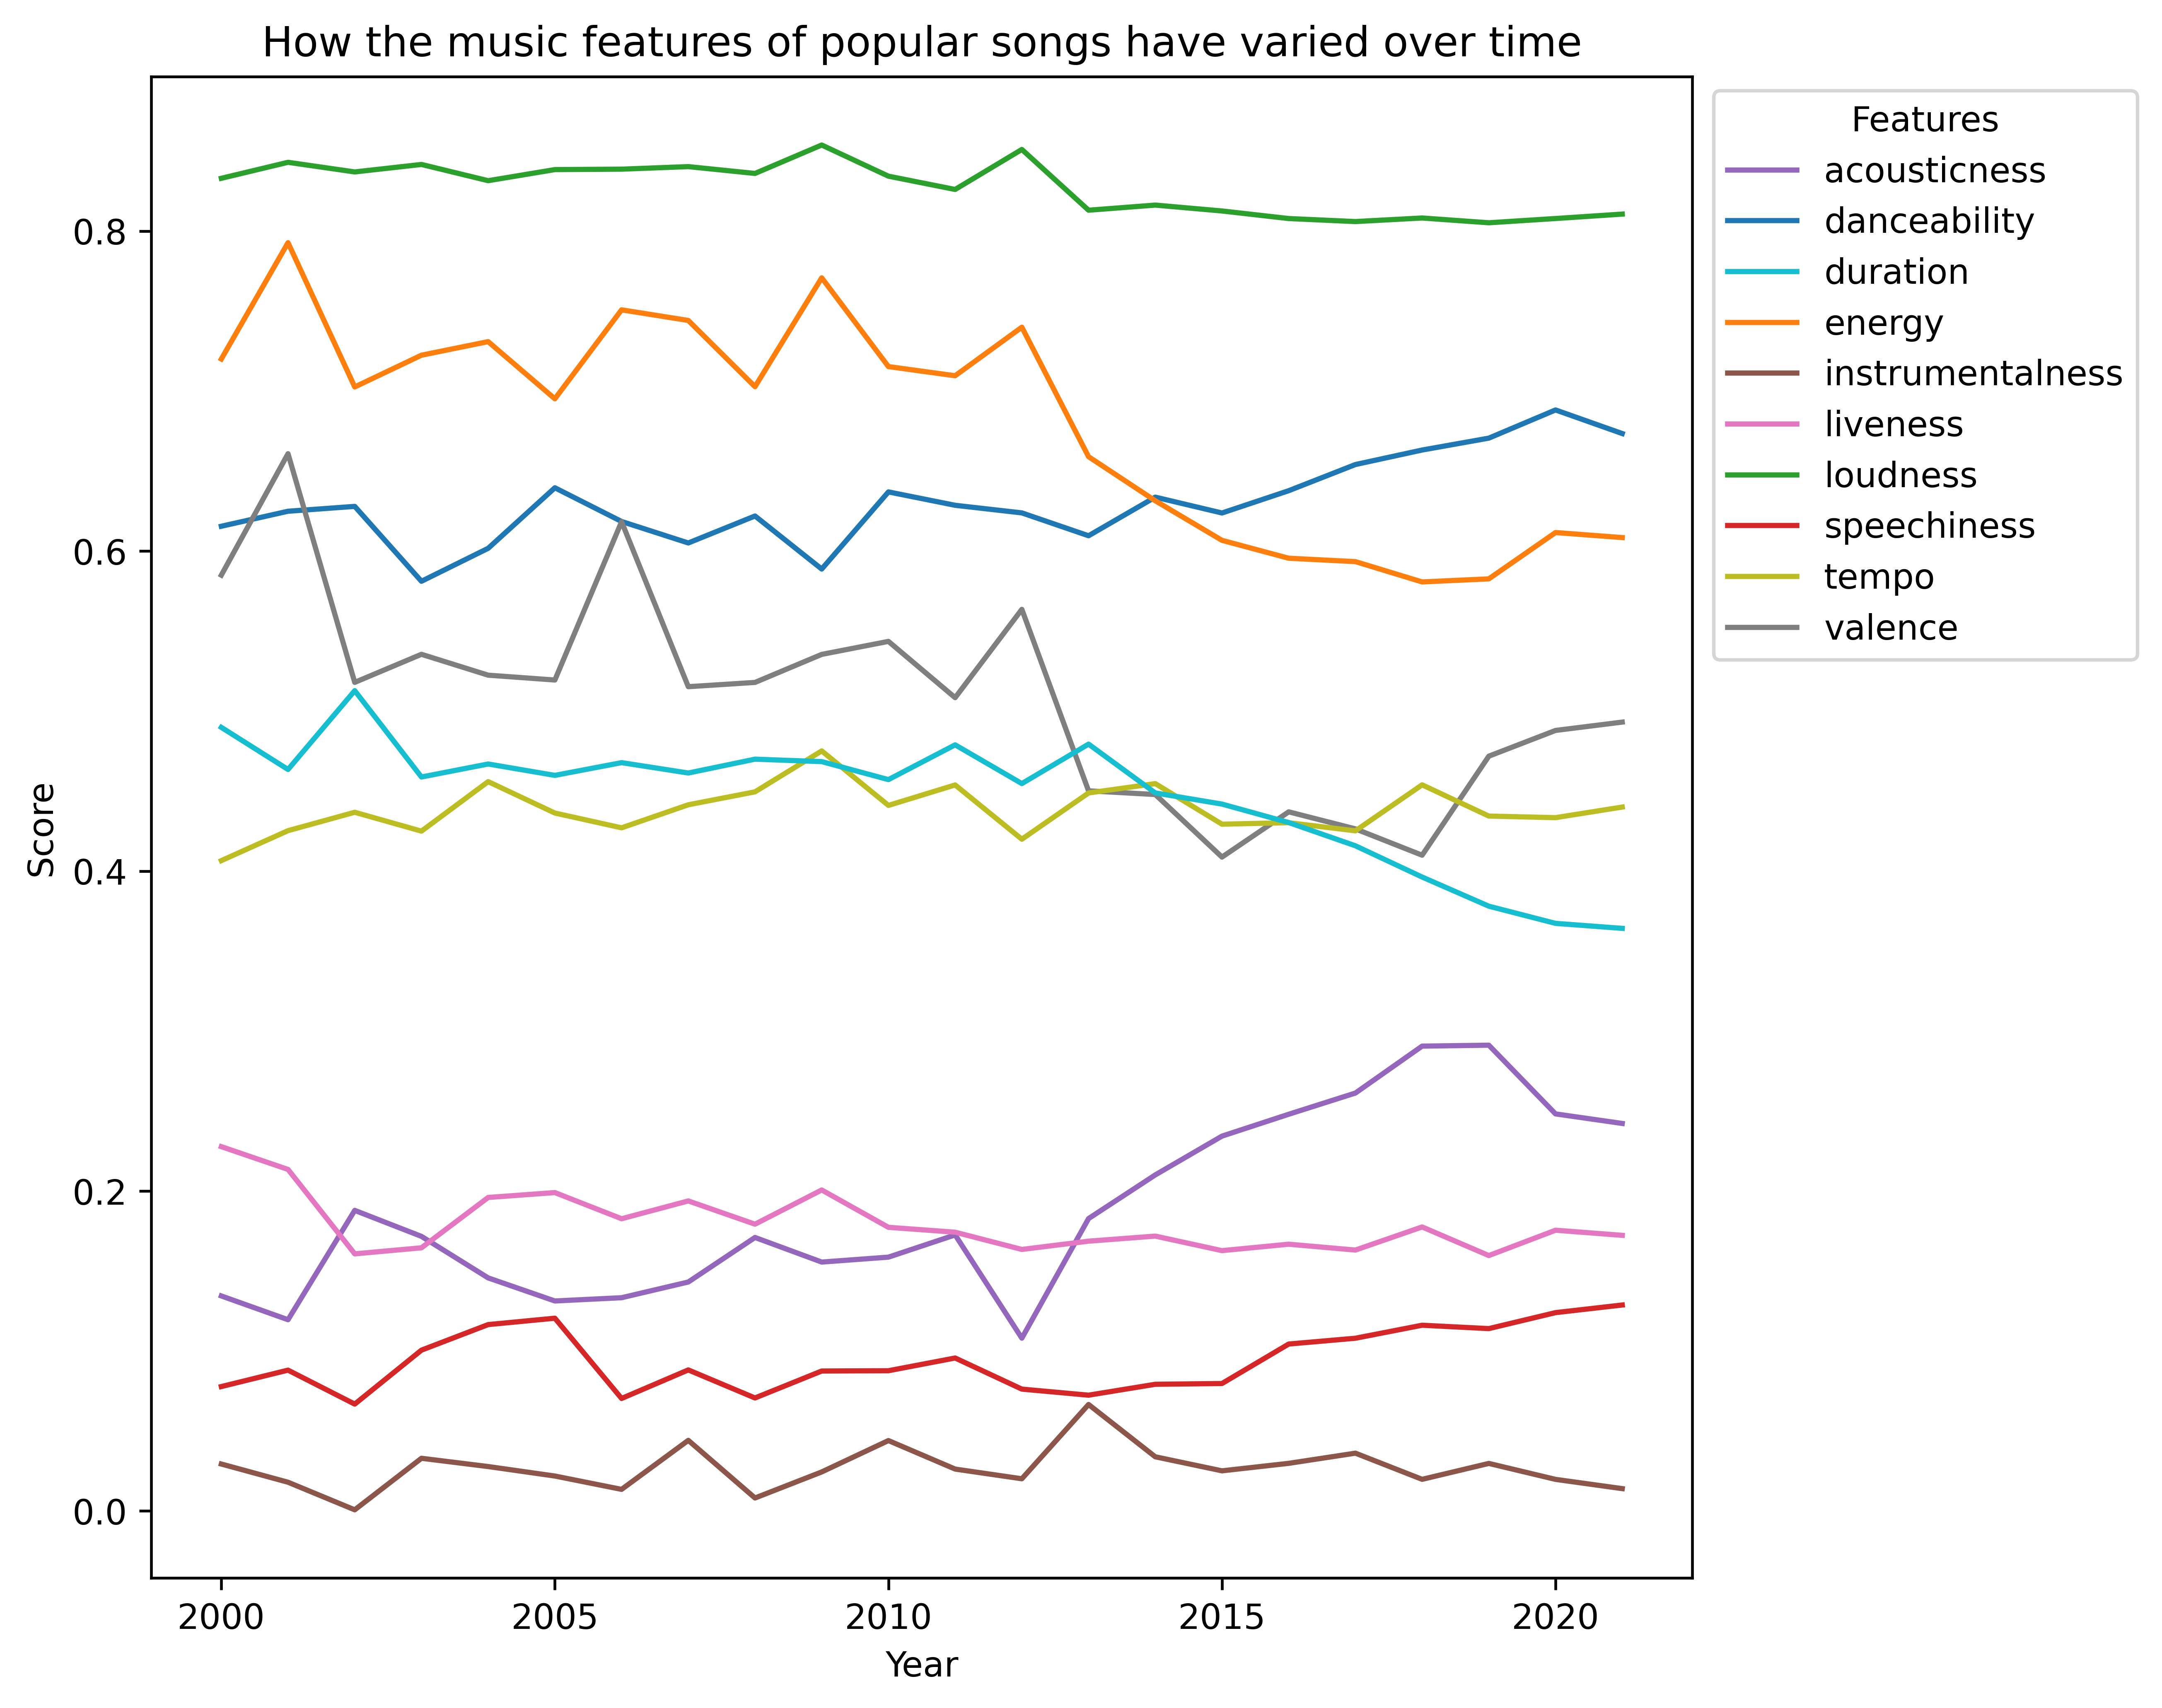

In [26]:
all_features =['danceability', 'energy', 'loudness',
               'speechiness', 'acousticness', 'instrumentalness',
               'liveness', 'valence', 'tempo', 'duration']

fig, ax = plt.subplots(figsize=(8,8), dpi=600)
for i in all_features:
    plt.plot(grouped[i], label=i)
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('How the music features of popular songs have varied over time')
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, title='Features', loc='lower right', bbox_to_anchor=(1.3, 0.6))
plt.show()

# Modelling

With the range of machine learning methods available, it is important that the most appropriate method is selected to perform the analysis. This is ultimately dependent on the structure of data. The dataset provided contains both the input variables and output variable, `popularity`.

This structure is conducive for supervised learning methods. Under this method, the algorithm is given the inputs, $x_i$, and desired outputs, $y$,with the aim of finding a rule that maps inputs to outputs, that is, $y=f(x)$. There are two umbrella fields of supervised learning:

* **Regression:** Used when the output variable takes continuous values
* **Classification:** Used when the output variable takes discrete / categorical values

Given that the target variable (expenditure) takes continuous values, a supervised learning regression model is the most appropriate machine learning method to start our analysis.

## Splitting the data
Before we begin, we first split the data into a training and testing set.

In [27]:
features =['year', 'danceability', 'energy', 'key', 'loudness_transform',
           'speechiness', 'acousticness', 'instrumentalness',
           'liveness', 'valence', 'tempo', 'duration']

In [28]:
X = data[features]
y = data['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model 1: Linear Regression

Before fitting a linear model, we visually inspect with a seaborn pairplot  and correlations plot [above](#correlations). We noted the 3 predictors with the highest absolute correlation with `popularity` are:
* Danceability
* Instrumentalness
* Loudness
* Liveness
* Year

When we first fit the data, we used `loudness` as opposed to `loudness_transform` which we derived by transforming the `loudness` variable to have a more normal distribution. This resulted in an $R^2$ value of 0.21. Using `loudness_transform` yielded better results.

We used Recursive Feature Elimination (RFE) selection to determine the best explanatory variables as:

|   |   |   |
|:--|:--|:--|
|Year | Danceability | Energy |
| Loudness (transformed) | Speechiness | Acousticness |
| Instrumentalness | Liveness | Valence|

Looking at the **R2 vs n_features** graph below, while more features produces higher accuracy, the marginal improvement is significantly outweighed by the increase in the number of parameters fitted. To ensure a parsimonious model, we selected the above 8 features.

Despite using the 9 best explanatory variables, the $R^2$ value is still undesirably low at 0.25. Additionally, the fitted values can be negative while the domain of the `popularity` variable is [0, 100].

In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe_output = []
bic_output = []
for i in range(1, 21):
    selector = RFE(lm, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)
    selected_cols = np.array(X_train.columns)[selector.support_]
    lm.fit(X_train[selected_cols], y_train)
    score = lm.score(X_test[selected_cols], y_test)
    rfe_output.append((i, selected_cols, round(score, 5)))

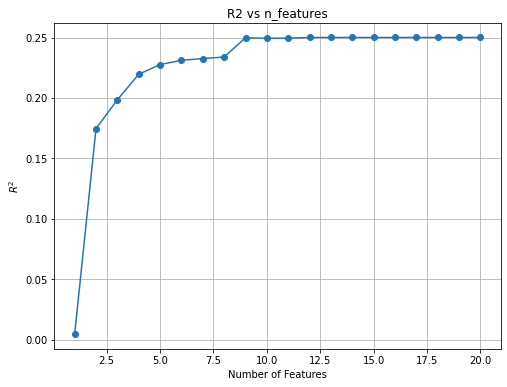

In [30]:
rfe = list(rfe_output)
rfe_df = pd.DataFrame(rfe, columns=['n_features', 'selected_features', 'score'])
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(rfe_df['n_features'], rfe_df['score'], '-o')
plt.xlabel('Number of Features')
plt.ylabel(r'$R^2$')
plt.title('R2 vs n_features')
plt.grid()
plt.show()

In [31]:
n = 9
chosen = list(rfe_df['selected_features'][n-1])
print(chosen)

['year', 'danceability', 'energy', 'loudness_transform', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


In [32]:
X = data[chosen]
y = data['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)

# Fitting the linear model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predicting and errors
lm_y_pred = lm.predict(X_test)
lm_r2 = lm.score(X_test, y_test)
lm_mae = mean_absolute_error(y_test, lm_y_pred)
lm_mse = mean_squared_error(y_test, lm_y_pred)
lm_rmse = np.sqrt(mean_squared_error(y_test, lm_y_pred))
print(f'R2:   {round(lm_r2, 2)}')
print(f"MAE:  {round(lm_mae, 2)}")
print(f"MSE:  {round(lm_mse, 2)}")
print(f"RMSE: {round(lm_rmse, 2)}")

R2:   0.25
MAE:  21.47
MSE:  637.28
RMSE: 25.24


In [33]:
def residuals(pred):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(x=pred, y=y_test-pred)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residual vs Fitted Values')
    plt.show()

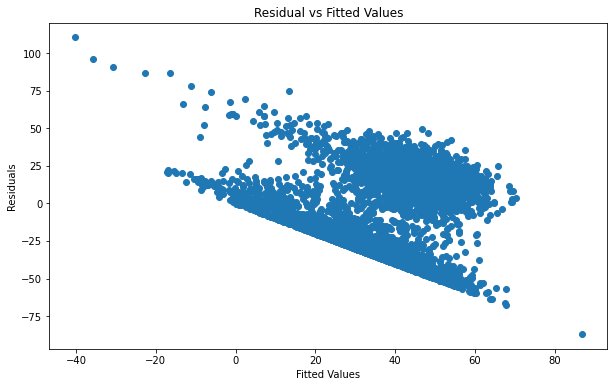

In [34]:
residuals(lm_y_pred)

## Model 2: Decision Tree
The next model we attempted to use for prediction was a decision tree. We experimented with a number of depth values from 1 to 15, to see which depth produced the better RMSE score. We ended up noting that a depth of 6 produced the better RMSE, so we used that for the decision tree model. Using the tree, we got a R2 score of 0.27, which is higher than the one we got for the first model, but it is still unhelpfully low.

In [35]:
max_depth_range = range(1, 15)

tree_rmse_scores = []

for depth in max_depth_range:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_mse= cross_val_score(tree, X, y, cv=10, scoring='neg_mean_squared_error')
    tree_rmse_scores.append(np.mean(np.sqrt(-tree_mse)))

plt.plot(max_depth_range, tree_rmse_scores, marker='X')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

In [37]:
tree = DecisionTreeRegressor(max_depth=6, random_state=42)
tree.fit(X_train, y_train)

tree_y_pred = dtr.predict(X_test)
tree_r2 = dtr.score(X_test, y_test)
tree_mae = mean_absolute_error(y_test, tree_y_pred)
tree_mse = mean_squared_error(y_test, tree_y_pred)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_y_pred))
print(f'R2:   {round(tree_r2, 2)}')
print(f"MAE:  {round(tree_mae, 2)}")
print(f"MSE:  {round(tree_mse, 2)}")
print(f"RMSE: {round(tree_rmse, 2)}")

R2:   0.27
MAE:  20.1
MSE:  619.72
RMSE: 24.89


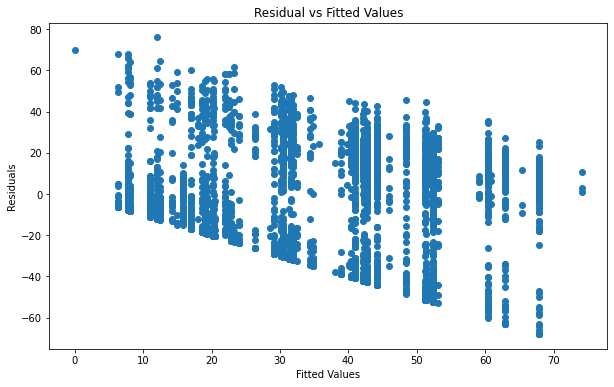

In [39]:
residuals(tree_y_pred)

## Model 3: Random Forest Regressor
The third model that we tried was the random forest regressor. For this model, we set the number of estimators to 9 as this was the number of variables most correlated with `popularity`. This produces significantly better predictions with an $R^2$ of 0.40.

In [40]:
rfReg = RandomForestRegressor(n_estimators=9, random_state=42)
rfReg.fit(X_train, y_train)
rfReg_y_pred = rfReg.predict(X_test)

rfReg_r2 = rfReg.score(X_test, y_test)
rfReg_mae = mean_absolute_error(y_test, rfReg_y_pred)
rfReg_mse = mean_squared_error(y_test, rfReg_y_pred)
rfReg_rmse = np.sqrt(mean_squared_error(y_test, rfReg_y_pred))
print(f'R2:   {round(rfReg_r2, 2)}')
print(f"MAE:  {round(rfReg_mae, 2)}")
print(f"MSE:  {round(rfReg_mse, 2)}")
print(f"RMSE: {round(rfReg_rmse, 2)}")

R2:   0.34
MAE:  18.29
MSE:  561.82
RMSE: 23.7


In [41]:
residuals(rfReg_y_pred)

## Model 4: KNN Classifier

So far, the linear, decision tree, and neural network regression models have very low predictive power. While we initially determined that a regression analysis was appropriate, the poor fitting has led us to explore other options including a pivot to a classification model.

To do this, we encoded `popularity` as either low, medium or high.

In [42]:
temp = copy.deepcopy(data)
temp['popularity'] = pd.cut(temp['popularity'], labels=[0, 1, 2], bins=3)
temp.head()[['artist_name', 'track_name', 'popularity']]

artist_name           track_name popularity
0    Powderfinger         My Happiness          1
1  Jonas Brothers            Year 3000          2
2        Coldplay               Yellow          2
3          Busted            Year 3000          1
4          Eminem  The Real Slim Shady          2

Next we look at the number of rows in each class. There is a clear imbalance with `high` being a minority class. This is an issue for classification problems as the algorithm does not get enough information to make an accurate prediction.

In [43]:
pd.DataFrame(temp['popularity'].value_counts())

popularity
0        9069
1        6921
2        4005

To solve this, we increased the number of samples in the minority class by **over-sampling**.

In [44]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(temp[features], temp['popularity'])

X_train, X_test, y_train, y_test = train_test_split(X_ros.values, y_ros.values, random_state=42, test_size=0.2)

### Finding the optimal k

Finally, we split the data into a training and testing set, and fit it to a k-nearest neighbour model. We vary the number of neighbours to determine the optimal value for the model.

In [45]:
knn_accuracy = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_y_pred = knn.predict(X_test)
    knn_accuracy.append(accuracy_score(y_test, knn_y_pred))
    
fig, ax = plt.subplots()
ax.plot(knn_accuracy, marker='X')
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy Score')
plt.show()

### KNN with optimal k

The optimal number of neighbours is clearly `n_neighbors=1`. This produces a significantly higher accuracy score of **0.72**!

In the **confusion matrix**, the diagnoal from the top left to the bottom right indicates the number of correctly identified clusters.

In [46]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print(f"Accuracy: {round(knn_accuracy, 2)}")

Accuracy: 0.72


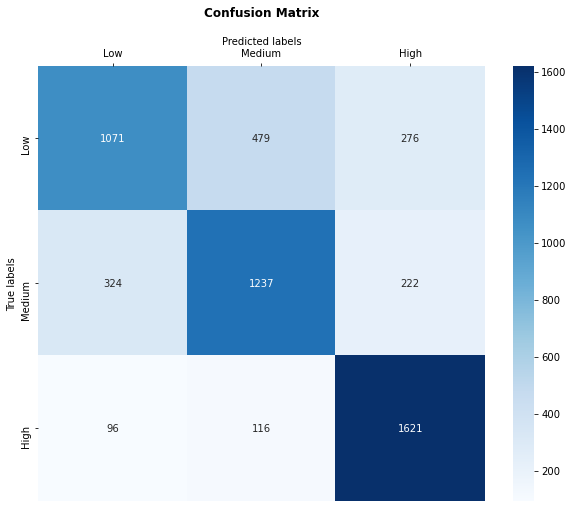

In [47]:
def cmatrix(cm, ax, title='Confusion Matrix'):
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette('Blues', as_cmap=True))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title, pad=20, weight='bold')
    ax.xaxis.set_label_position('top') 
    ax.xaxis.set_ticklabels(['Low', 'Medium', 'High'])
    ax.yaxis.set_ticklabels(['Low', 'Medium', 'High'])
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

knn_cm = confusion_matrix(y_test, knn_y_pred)
fig, ax = plt.subplots(figsize=(10,8))
cmatrix(knn_cm, ax)
plt.show()

## Model 5: Gaussian Naive Bayes

For the next few models, we moved from predictive models to classification models. The first of the models we tried (the fifth, overall) was Gaussian Naive Bayes. The results of the model were encouraging, getting an accuracy score of 0.6. Though this is not an extraordinary score, this shows that the model is somewhat useful at least.

Accuracy: 0.6


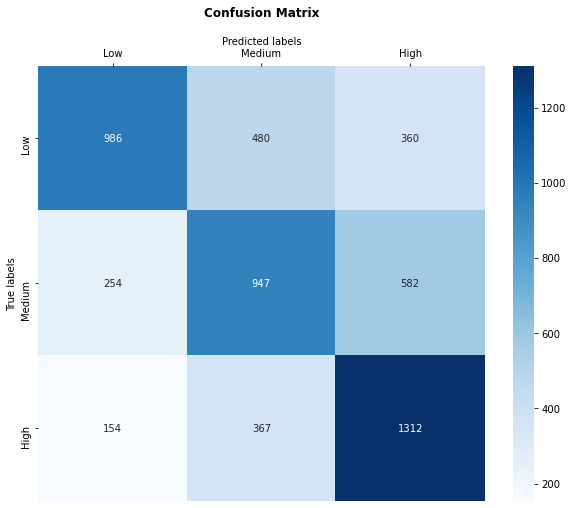

In [48]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
gnb_accuracy = accuracy_score(y_test, gnb_y_pred)
print(f"Accuracy: {round(gnb_accuracy, 2)}")

gnb_cm = confusion_matrix(y_test, gnb_y_pred)
fig, ax = plt.subplots(figsize=(10,8))
cmatrix(gnb_cm, ax)
plt.show()

## Model 6: Random Forest Classifier

The next model we attempted uses mulitple decision trees with various samples of the dataset this will improve predictive accruacy and controls over-fitting with the help of averaging. This does produce an accuracy score of 0.61 which shows that the model is useful and accurate even though the score isn't neccessairly the highest. 

In [49]:
rfClass = RandomForestClassifier(max_depth=2, random_state=42)
rfClass.fit(X_train, y_train)
rfClass_y_pred = rfClass.predict(X_test)
rfClass_accuracy = accuracy_score(y_test, rfClass_y_pred)
print(f"Accuracy: {round(rfClass_accuracy, 2)}")

rfClass_cm = confusion_matrix(y_test, rfClass_y_pred)
fig, ax = plt.subplots(figsize=(10,8))
cmatrix(rfClass_cm, ax)
plt.show()

Accuracy: 0.61


## Model 7: Neural Network

With limited computing power, we set the max number of iterations to 100 and instead varied the solver across `lbfgs`, `sgd` and `adam`. We found that the `lbfgs` solver produced the best model.

In [50]:
%%time

solver = ['lbfgs', 'sgd', 'adam']
solver_score = []
for i in solver:
    clf = MLPClassifier(solver=i, max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    clf_y_pred = clf.predict(X_test)
    solver_score.append(accuracy_score(y_test, clf_y_pred))

fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(solver, solver_score, marker='x')
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.show()

Wall time: 33.2 s


In [51]:
%%time

clf = MLPClassifier(solver='lbfgs', max_iter=500, random_state=42)
clf.fit(X_train, y_train)
clf_y_pred = clf.predict(X_test)
clf_accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {round(clf_accuracy, 2)}")

Accuracy: 0.53
Wall time: 32.7 s


In [52]:
clf_cm = confusion_matrix(y_test, clf_y_pred)
fig, ax = plt.subplots(figsize=(10,8))
cmatrix(clf_cm, ax)
plt.show()

## Model 8: Combining KNN with Random Forest Regression

Although the KNN model had desirable predictive capabilities, we felt it was limited in its use as it classifies for a range:

- **Low:** 0 to 33
- **Medium:** 34 to 66
- **High:** 67 to 100

This is opposed to a regression model which returns an actual value.

Thus, we attempted one final model which incorporated the best performing classification model and the best performing regression model. After fitting the data to the KNN model (Model 4), we added its output to the data and used it as an input for the random forest regression.

We tuned the model by varying the maximum depth of the tree which ultimately produced a reasonable model with an $R^2$ of 0.63.

In [53]:
comb_data = copy.deepcopy(data)
comb_data['cluster'] = knn.predict(comb_data[features])
comb_data.head(3)

artist_name    track_name  popularity  year  danceability  energy  key  \
0    Powderfinger  My Happiness          65  2000         0.445   0.823    0   
1  Jonas Brothers     Year 3000          67  2000         0.659   0.857   11   
2        Coldplay        Yellow          86  2000         0.429   0.661   11   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -5.415     1       0.0302       0.00163          0.000000     0.430   
1    -5.850     1       0.0437       0.00450          0.000002     0.335   
2    -7.227     1       0.0281       0.00239          0.000121     0.234   

   valence    tempo  time_signature  duration  loudness_transform  cluster  
0    0.487   85.935               4  4.610450           -2.085548        1  
1    0.798  106.965               4  3.366000           -2.138182        2  
2    0.285  173.372               4  4.446217           -2.288588        2

In [54]:
new_features = copy.deepcopy(features)
new_features.append('cluster')
new_features.remove('year')

X = comb_data[new_features]
y = comb_data['popularity']

Finding the optimal depth:

In [55]:
max_depth_range = range(1, 10)

comb_rmse_scores = []

for depth in max_depth_range:
    comb = RandomForestRegressor(max_depth=depth, random_state=42)
    comb_mse= cross_val_score(comb, X, y, cv=10, scoring='neg_mean_squared_error')
    comb_rmse_scores.append(np.mean(np.sqrt(-comb_mse)))

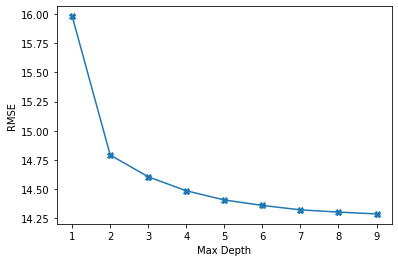

In [56]:
fig, ax = plt.subplots()
ax.plot(max_depth_range, comb_rmse_scores, marker='X')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

comb = RandomForestRegressor(max_depth=3, random_state=42)
comb.fit(X_train, y_train)
comb_y_pred = comb.predict(X_test)

comb_r2 = comb.score(X_test, y_test)
comb_mae = mean_absolute_error(y_test, comb_y_pred)
comb_mse = mean_squared_error(y_test, comb_y_pred)
comb_rmse = np.sqrt(mean_squared_error(y_test, comb_y_pred))
print(f'R2:   {round(comb_r2, 2)}')
print(f"MAE:  {round(comb_mae, 2)}")
print(f"MSE:  {round(comb_mse, 2)}")
print(f"RMSE: {round(comb_rmse, 2)}")

R2:   0.64
MAE:  10.76
MSE:  309.46
RMSE: 17.59


In [60]:
from sklearn import tree
plt.figure(figsize=(40,20))
_ = tree.plot_tree(comb.estimators_[0], feature_names=X.columns, filled=True)

# Evaluation

While the k-nearest neighbours model had the highest accuracy score of 0.72, this is overshadowed by the fact its limited use. Instead of predicting a `popularity` score, it only gives us a range of possible scores a song may achieve.

To improve on this, we combined the KNN model output with a random forest regression model. This provided a coefficient of determination ($R^2$) of 0.65. This is the final model we settled on.

## Regression

The graphs below show a summary of each regression model's $R^2$, mean absolute error (MAE), and mean squared error (MSE).

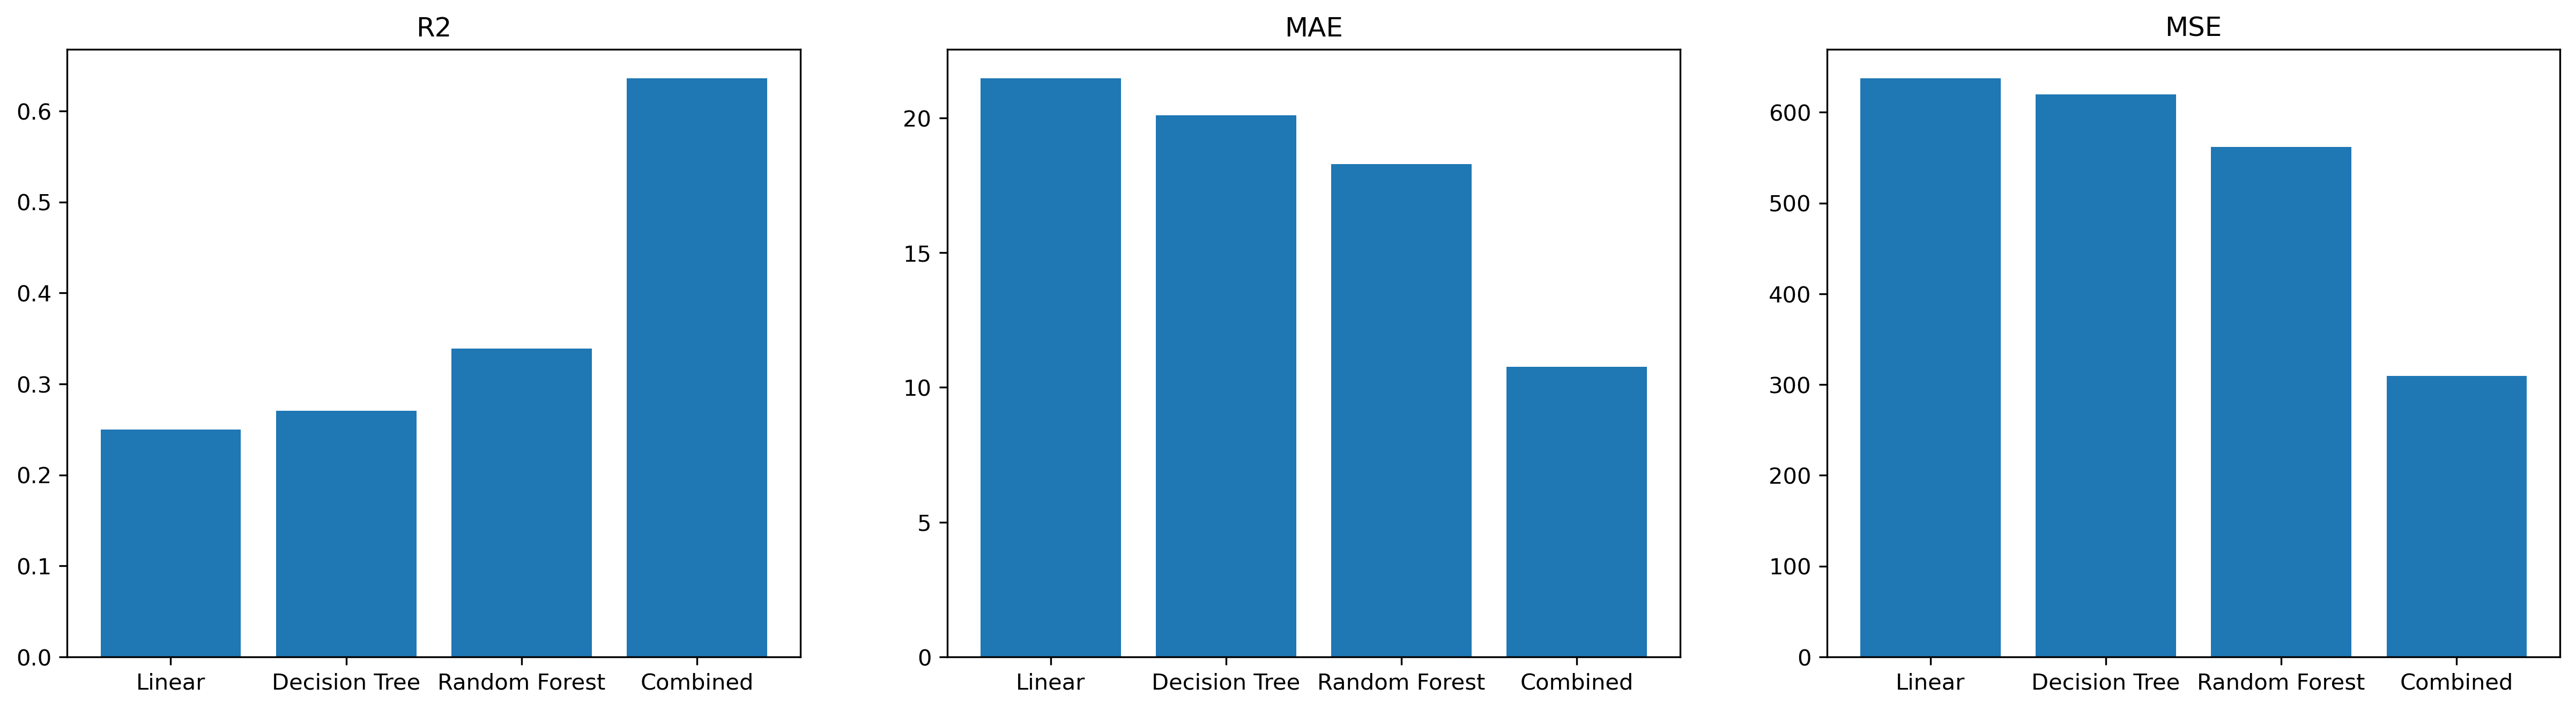

In [62]:
errors_df = {'model':['Linear', 'Decision Tree', 'Random Forest', 'Combined'],
             'r2':[lm_r2, tree_r2, rfReg_r2, comb_r2],
             'mae':[lm_mae, tree_mae, rfReg_mae, comb_mae],
             'mse':[lm_mse, tree_mse, rfReg_mse, comb_mse],
             'rmse':[lm_rmse, tree_rmse, rfReg_rmse, comb_rmse]}
errors = pd.DataFrame.from_dict(errors_df, orient='columns').set_index('model')

fig, ax = plt.subplots(1, 3, figsize=(20,5), sharex=True, dpi=300)
ax[0].set_title('R2')
ax[0].bar(errors.index, errors['r2'])
ax[1].set_title('MAE')
ax[1].bar(errors.index, errors['mae'])
ax[2].set_title('MSE')
ax[2].bar(errors.index, errors['mse'])
plt.show()

In [63]:
errors

r2        mae         mse       rmse
model                                                    
Linear         0.249872  21.468305  637.284741  25.244499
Decision Tree  0.270541  20.101379  619.724593  24.894268
Random Forest  0.338693  18.287395  561.824937  23.702847
Combined       0.635742  10.759197  309.461964  17.591531

## Classification

The confusion matrices below summarises the prediction results of each classification model.

In [64]:
print(f"KNN: {round(knn_accuracy, 2)}")
print(f"Neural Network: {round(clf_accuracy, 2)}")
print(f"Random Forest: {round(rfClass_accuracy, 2)}")
print(f"GNB: {round(gnb_accuracy, 2)}")

KNN: 0.72
Neural Network: 0.53
Random Forest: 0.61
GNB: 0.6


In [65]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12), tight_layout=True, dpi=600)
cmatrix(knn_cm, ax[0,0], 'KNN')
cmatrix(clf_cm, ax[0,1], 'Neural Network')
cmatrix(rfClass_cm, ax[1,0], 'Random Forest')
cmatrix(gnb_cm, ax[1,1], 'GNB')
plt.show()

<a id='Conclusion'></a>
# Conclusion

Every popular musician has their unique musical style. Ed Sheeran, for example, is a huge fan of acoustic guitar; Drake has perfected the art of rapping; Adele can hit exceptionally high notes in her pop ballads; and Kygo, whose DJ performance is filled with EDM enchantment. Music is about uniqueness, creativity, inspiration, and passion, and it is an excellent way of bringing people from all walks of life together. 

This brings us to a question that many aspiring and successful musicians want to know the answer to: 

> WHAT MAKES A SONG UNIQUE, AND WHAT QUALITIES SHOULD A SONG HAVE IN ORDER TO BECOME A HIT?
>> **In other words, can we really predict what makes a song a hit?**

To address this question, we relied on a variety of musical features (danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and duration) retrieved from Spotify's API to assist us in predicting whether or not a song will be a hit. Despite the fact that our results appear to be optimistic, our results demonstrates that there is no magic formula yet that can help us predict a song being a hit before it is released.

When we first started working on this project, we all had our own ideas about what qualities could make a hit song. However, our analysis of the Spotify data has yielded models with weak predictive capabilities. This demonstrates how difficult it is to predict something as subjective as music, since other factors contribute to a hit song:

* One factor is the assumption that a song can become enormously popular as a consequence of advertising. Music is frequently utilised in movies and television advertising to help convey a message. Since many people see or hear these advertisements, it is not rare for a song to become so well-known that it tops the record charts. This series of events can happen so quickly that it is impossible to keep track of it, making it difficult to predict the song.
* Another factor to consider is radio airplay. Several radio stations have a weekly feature in which, for example, they select a single song that receives additional airplay for the next seven days. This can dramatically boost the song's popularity and chances of becoming a hit.
* Other factors like if a song has a good featuring artist, is it released at the right moment, how popular is the artist who released the song, all play a role in whether a song makes it to the charts.

We would have loved to incorporate all of this metadata into our prediction, however Spotify's Web API does not contain this sort of information. We would of had to outsource this data from somewhere else. We believe these factors could be an essential element in future studies.

Even though our predictive model does not fully answer our question, music producers and musicians can still apply our model to better understand their audiences and create songs that their fans will enjoy hearing; artists can better understand what lyrics to write and tailor the message of their songs to what their fan base would enjoy hearing; and audio engineers can collaborate with artists to improve inherent musical aspects in order to make a song more popular, catchy, and unforgettable.

### Limitations

There was only one limitation in this study:

* We were restricted to just looking at music from 2000 to 2021. If we could travel further back in time and examine a different era of music, we might be able to find additional cyclical tendencies that can be employed.

### Next Steps

In the future, we could look at a few more factors to help us build a more complex model with more computational power, such as:

* Including data from other platforms, such as TikTok and YouTube. Is it true that these platforms promote song popularity? For example, is a specific type of song being utilised to perform a trendy TikTok dance?
* How popular is the artist? Is there a large social media following for that particular artist?
* Whether an artist is signed to a record label, and if so, which one?
* How much radio airplay does a song receive? Does this have an impact on its popularity?
* Is there a difference in the popularity of a song with a featured artist vs a song without a featured artist?
* When is the best time to release a song? Is it critical to release a song at the right time in order for it to be successful?

We can additionally divide **POPULARITY** into subcategories based on:

* Region
* Demographics
* Which device is the music streaming on?
* Number of shared Spotify accounts

With these aditional factors added to our dataframe, it would be interesting to observe how our model evolves, maybe to the point where hit songs can be predicted before they are released.